# Install and import necessary packages

In [37]:
!pip install tqdm_notebook > /dev/null 2>&1

In [38]:
!pip install scispacy > /dev/null 2>&1

In [39]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz > /dev/null 2>&1

In [40]:
#Import Libraries

import csv
import random
import numpy as np
import pandas as pd
import html
import re

# Plotting
import matplotlib.pyplot as plt

import scispacy
import spacy
import en_core_sci_lg

# from tqdm import tqdm
%matplotlib inline

In [41]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from tqdm.notebook import tqdm_notebook as tqdm
  tqdm.pandas()
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [42]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data/"

# Data cleaning

In [43]:
df = pd.read_csv(base_path+"metadata.csv", low_memory=False)
df.info(verbose=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497906 entries, 0 to 497905
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          497906 non-null  object 
 1   sha               172105 non-null  object 
 2   source_x          497906 non-null  object 
 3   title             497674 non-null  object 
 4   doi               281753 non-null  object 
 5   pmcid             182522 non-null  object 
 6   pubmed_id         241936 non-null  object 
 7   license           497906 non-null  object 
 8   abstract          363064 non-null  object 
 9   publish_time      497687 non-null  object 
 10  authors           484020 non-null  object 
 11  journal           464755 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  197568 non-null  object 
 14  arxiv_id          6687 non-null    object 
 15  pdf_json_files    172105 non-null  object 
 16  pmc_json_files    13

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [44]:
# load the meta data from the CSV file and extract out fields that will be useful to our application

df = df[['title','abstract','publish_time', 'sha']]
df = df.drop_duplicates(subset='abstract', keep="first")
df=df.dropna()
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()

Only choose the articles related to COVID-19 for this project.

In [45]:
is_covid19_abstract = df.abstract.str.contains('coronavirus|covid')
is_covid19_title = df.title.str.contains('coronavirus|covid')

In [46]:
df = df[is_covid19_abstract | is_covid19_title]

In [47]:
df.shape

(63952, 4)

In [183]:
df.head()

,title,abstract,publish_time,sha
2247,"infection, replication, and transmission of mi...",middle east respiratory syndrome coronavirus i...,2016-06-29,b8c816b6461d1c8bf4603f85f6e9841c172a8bc1
2769,36th international symposium on intensive care...,p001 - sepsis impairs the capillary response w...,2016-04-20,b30770ae30b35cdfaf0a173863e74e93edbb0329
4540,therapeutic strategies in an outbreak scenario...,a novel coronavirus (2019-ncov) originating in...,2020-02-07,5a17ed3e4abf295f5820c65f56398266c1baae98
8221,baricitinib - a januase kinase inhibitor - not...,• several studies suggested baricitinib as a p...,2020-04-04,04383994da0f349f314e59c9a414a9c8cc5b4448
9981,bronchial inflammation and the common cold: a ...,background cold virus infections are associate...,2006-04-27,a1a53eb2c0eb54dc469ab6d7038af601fbabff05


We use scispaCy for preprocessing, which is a Python package containing spaCy models for processing scientific text.

In [49]:
nlp = en_core_sci_lg.load(disable=["parser", "ner"])
nlp.max_length = 2000000

In [50]:
def clean_text(sentence):
  sentence = html.unescape(sentence) # replaces HTML charachter codes with ASCII equivalent
  sentence = re.sub(r"http\S+", "", sentence) # removes URL links
  wordsList = []
  for word in nlp(sentence):
    if not (word.is_stop or word.is_space or word.like_num or word.is_punct or len(word)<2):
      wordsList.append(word.lemma_)
  return " ".join(wordsList)

Add customize stop words

In [51]:
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'https', 'author', 'figure', 'table',
    'rights', 'reserved', 'permission', 'use', 'biorxiv', 'medrxiv', 
    'license', 'fig', 'fig.', 'al.', 'PMC', 'CZI', 
    'br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', \
    "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', \
    'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", \
    'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', \
    'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', \
    'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', \
    'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
    'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', \
    'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', \
    'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', \
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'only', \
    'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", \
    'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", \
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', \
    "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', \
    "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", \
    'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]
for word in customize_stop_words:
    nlp.vocab[word].is_stop = True

Apply the nlp model to title and abstract columns.

In [52]:
def clean_df(data):
  data['cleaned_title'] = data['title'].progress_apply(clean_text)
  data['cleaned_abstract'] = data['abstract'].progress_apply(clean_text)
# clean_df(df)

Convert the publish time to datetime object, and categorize the time into year and month separately.

In [53]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
def categorize_time(data):
  data['publish_year'] = data['publish_time'].dt.year
  data['publish_month'] = data['publish_time'].dt.month
# categorize_time(df)

Save the preprocessed dataframe

In [54]:
# df.to_csv(base_path + "preproced_metadata.csv")

# Data visualization

In [77]:
proced_df = pd.read_csv(base_path + "preproced_metadata.csv", low_memory=False)

In [78]:
proced_df = proced_df.dropna()

In [56]:
proced_df.head()

,Unnamed: 0,title,abstract,publish_time,sha,cleaned_title,cleaned_abstract,publish_year,publish_month,publish_date
0,2247,"infection, replication, and transmission of mi...",middle east respiratory syndrome coronavirus i...,2016-06-29,b8c816b6461d1c8bf4603f85f6e9841c172a8bc1,infection replication transmission middle east...,middle east respiratory syndrome coronavirus r...,2016,6,29
1,2769,36th international symposium on intensive care...,p001 - sepsis impairs the capillary response w...,2016-04-20,b30770ae30b35cdfaf0a173863e74e93edbb0329,international symposium intensive care emergen...,p001 sepsis impair capillary response hypoxic ...,2016,4,20
2,4540,therapeutic strategies in an outbreak scenario...,a novel coronavirus (2019-ncov) originating in...,2020-02-07,5a17ed3e4abf295f5820c65f56398266c1baae98,therapeutic strategy outbreak scenario treat n...,novel coronavirus 2019-ncov originate wuhan ch...,2020,2,7
3,8221,baricitinib - a januase kinase inhibitor - not...,• several studies suggested baricitinib as a p...,2020-04-04,04383994da0f349f314e59c9a414a9c8cc5b4448,baricitinib januase kinase inhibitor ideal opt...,study suggest baricitinib potential drug manag...,2020,4,4
4,9981,bronchial inflammation and the common cold: a ...,background cold virus infections are associate...,2006-04-27,a1a53eb2c0eb54dc469ab6d7038af601fbabff05,bronchial inflammation common cold comparison ...,background cold virus infection associate asth...,2006,4,27


## publish year distribution

As we can see, most of the articles articles published in 2020, so filtering the articles by year would not be very helpful. Therefore, we can add month to the filtering condition to help user filter the articles according to the publish time more accurately. 

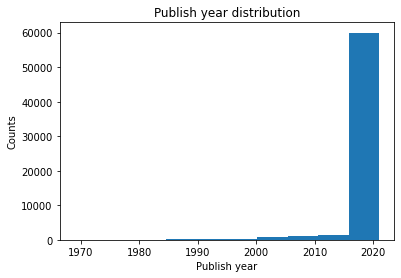

In [57]:
proced_df['publish_year'].plot.hist()
plt.xlabel('Publish year')  
plt.ylabel('Counts')
plt.title('Publish year distribution')
plt.show()

## Plot word frequency for abstract

In [58]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [214]:
def get_word_freq(data, top_N=20):
  preproced_data = data.str.cat(sep=' ')
  words = nltk.tokenize.word_tokenize(preproced_data)
  words_selected = [i for i in words if len(i) > 2]
  words_dist = nltk.FreqDist(words_selected)
  words_freq = pd.DataFrame(words_dist.most_common(top_N),
                      columns=['Word', 'Frequency'])
  return words_freq, words_dist

In [218]:
from wordcloud import WordCloud
def draw_word_cloud(word_dist, title):
  wordcloud = WordCloud(width=800, height=500, max_font_size=110).generate_from_frequencies(word_dist)
  plt.figure(figsize=(10, 10))
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.title("Title words cloud")
  plt.axis('off')
  plt.show()

In [215]:
abstract_words_freq, abstract_words_dist = get_word_freq(proced_df['cleaned_abstract'], top_N=20)

In [61]:
abstract_words_freq

,Word,Frequency
0,covid-19,151425
1,patient,108543
2,study,57206
3,disease,52578
4,pandemic,50442
5,sars-cov-2,48048
6,infection,45569
7,result,44614
8,coronavirus,40841
9,case,39566


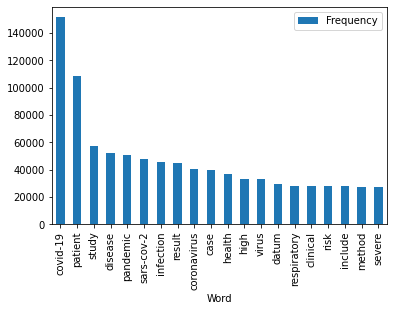

In [62]:
abstract_words_freq.plot(x='Word', y='Frequency', kind='bar')

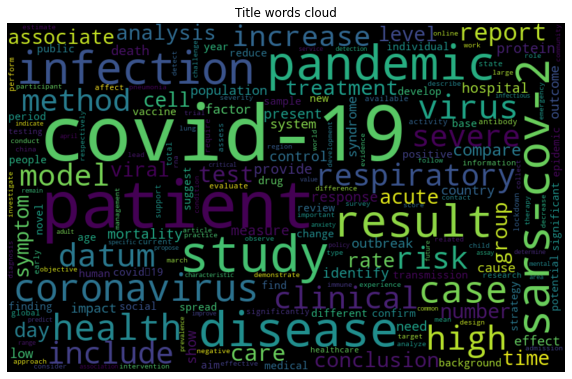

In [219]:
draw_word_cloud(abstract_words_dist, "Abstract word cloud")

## Plot word frequency for title

In [220]:
title_words_freq, title_words_dist = get_word_freq(proced_df['cleaned_title'], top_N=20)

In [64]:
title_words_freq

,Word,Frequency
0,covid-19,35540
1,pandemic,9459
2,patient,9214
3,sars-cov-2,8382
4,coronavirus,7703
5,study,5664
6,infection,5086
7,disease,5034
8,covid‐19,3793
9,impact,3399


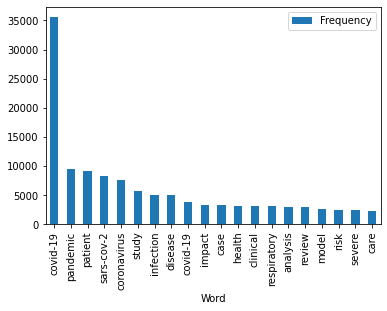

In [65]:
title_words_freq.plot(x='Word', y='Frequency', kind='bar')

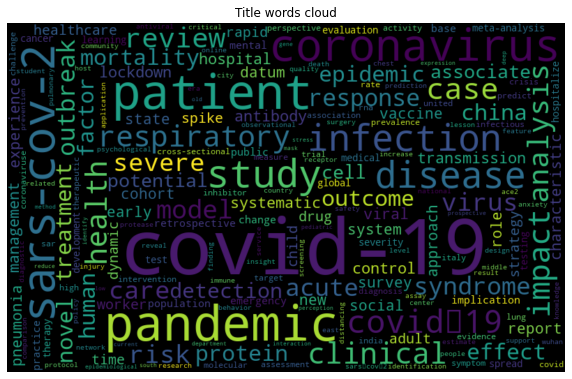

In [221]:
draw_word_cloud(title_words_dist, "Title word cloud")

## Data visualization summary

By visualizing the data, I find out that words directly related Covid-19 appears very frequently in both title and abstract. Therefore, if we want to make distictions and calculate meaningful distances between articles, we have to ignore words that appears most frequent in title and abstract

# Model selection and fitting to the data

In [104]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(proced_df, test_size=0.1, random_state=42)

In [121]:
from sklearn.base import TransformerMixin
from sklearn.neighbors import NearestNeighbors
class NNWrapper(TransformerMixin):
  def __init__(self, knn_args):
    self.knn = NearestNeighbors(**knn_args)

  def fit(self, X, y=None):
    self.knn.fit(X)

  def predict(self, X, **predict_params):
    return self.knn.kneighbors(X, predict_params['n_neighbors'], predict_params['return_distance'])

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


def train(train_df, title_args, abstract_args, knn_args):
  preprocess = ColumnTransformer([
                                  ('title', TfidfVectorizer(**title_args), 'cleaned_title'),
                                  ('abstract', TfidfVectorizer(**abstract_args), 'cleaned_abstract')
                                  ], remainder = 'drop', n_jobs=-1)
          
  pipe = Pipeline([
                  ('preprocess', preprocess),
                  ('model', NNWrapper(knn_args))
          ],
          verbose=True)
  pipe.fit(train_df)
  return pipe

In [189]:
MAX_FEATURES_TITLE = 1000
MAX_FEATURES_ABSTRACT = 10000
title_args = {'min_df': 0.1,  'max_df':0.9,'max_features': MAX_FEATURES_TITLE, 'ngram_range': (1, 3)}
abstract_args = {'min_df': 0.1,  'max_df':0.9, 'max_features': MAX_FEATURES_ABSTRACT, 'ngram_range': (1, 4)}
knn_args = {'n_neighbors': 3, 'leaf_size': 30, 'n_jobs': -1}
model = train(train_df, title_args, abstract_args, knn_args)

[Pipeline] ........ (step 1 of 2) Processing preprocess, total= 4.2min
[Pipeline] ............. (step 2 of 2) Processing model, total=   0.0s


In [190]:
def get_kneighbors(model, X, k=3, return_distance=True):
  return model.predict(X, n_neighbors=k, return_distance=return_distance)

In [191]:
def recommand(model, paper, database, no_earlier=None, k=3):
  dists, nn = get_kneighbors(model, paper, k)
  recommand_papers = database.iloc[nn[0], :].copy()
  recommand_papers['distance'] = dists[0]
  if no_earlier:
    return recommand_papers[recommand_papers['publish_year'] < no_earlier]
  return recommand_papers

## Test the model

In [205]:
test_paper = test_df.iloc[[1]]

In [206]:
test_paper

,Unnamed: 0,title,abstract,publish_time,sha,cleaned_title,cleaned_abstract,publish_year,publish_month,publish_date
15777,375300,potential of arbidol for post-exposure prophyl...,the efficient transmission of severe acute res...,2020-05-30,6ce9184873d7c7e86be2ff009d2a9012274e8293,potential arbidol post-exposure prophylaxis co...,efficient transmission severe acute respirator...,2020,5,30


In [207]:
recommand_papers = recommand(model, test_paper, train_df, k=5)

In [208]:
recommand_papers

,Unnamed: 0,title,abstract,publish_time,sha,cleaned_title,cleaned_abstract,publish_year,publish_month,publish_date,distance
22959,394003,covid-19 in health-care workers in three hospi...,background: 10 days after the first reported c...,2020-07-02,307dc2144632d5a3294f9d85b434b22ecad2edcf; 67ef...,covid-19 health-care worker hospital south net...,background day report case severe acute respir...,2020,7,2,0.677627
19287,384338,risk of covid-19 in health-care workers in den...,background: health-care workers are thought to...,2020-08-03,a831b8d089ccaa7c841502b89353ddc8fcef8fb8; c8b4...,risk covid-19 health-care worker denmark obser...,background health-care worker think highly exp...,2020,8,3,0.722125
62295,493898,breastfeeding in covid-19: a pragmatic approach,the novel coronavirus disease 2019 (covid-19) ...,2020-09-08,cadd6961df2fa13753dda3caa2a08e17f82966e9,breastfeed covid-19 pragmatic approach,novel coronavirus disease covid-19 pandemic re...,2020,9,8,0.781314
56529,479498,endoscopic intervention in a case proven latte...,background: covid-19 pandemic caused by severe...,2020-11-25,ea38ff1de53478d01321b997295ddd917102853d,endoscopic intervention case prove covid-19,background covid-19 pandemic cause severe acut...,2020,11,25,0.783223
33015,420133,telemedicine in liver disease and beyond: can ...,evidence strongly supports that access to spec...,2020-04-10,bb4a8493e81cdf57004a7f40be2884b8918c3503,telemedicine liver disease covid‐19 crisis lea...,evidence strongly support access specialty gas...,2020,4,10,0.809385


In [209]:
recommand_papers_2020 = recommand(model, test_paper, train_df, k=5, no_earlier=2021)

In [210]:
recommand_papers_2020

,Unnamed: 0,title,abstract,publish_time,sha,cleaned_title,cleaned_abstract,publish_year,publish_month,publish_date,distance
22959,394003,covid-19 in health-care workers in three hospi...,background: 10 days after the first reported c...,2020-07-02,307dc2144632d5a3294f9d85b434b22ecad2edcf; 67ef...,covid-19 health-care worker hospital south net...,background day report case severe acute respir...,2020,7,2,0.677627
19287,384338,risk of covid-19 in health-care workers in den...,background: health-care workers are thought to...,2020-08-03,a831b8d089ccaa7c841502b89353ddc8fcef8fb8; c8b4...,risk covid-19 health-care worker denmark obser...,background health-care worker think highly exp...,2020,8,3,0.722125
62295,493898,breastfeeding in covid-19: a pragmatic approach,the novel coronavirus disease 2019 (covid-19) ...,2020-09-08,cadd6961df2fa13753dda3caa2a08e17f82966e9,breastfeed covid-19 pragmatic approach,novel coronavirus disease covid-19 pandemic re...,2020,9,8,0.781314
56529,479498,endoscopic intervention in a case proven latte...,background: covid-19 pandemic caused by severe...,2020-11-25,ea38ff1de53478d01321b997295ddd917102853d,endoscopic intervention case prove covid-19,background covid-19 pandemic cause severe acut...,2020,11,25,0.783223
33015,420133,telemedicine in liver disease and beyond: can ...,evidence strongly supports that access to spec...,2020-04-10,bb4a8493e81cdf57004a7f40be2884b8918c3503,telemedicine liver disease covid‐19 crisis lea...,evidence strongly support access specialty gas...,2020,4,10,0.809385


In [211]:
# title_args = {'min_df': 0.1, 'max_df':0.95, 'max_features': MAX_FEATURES_TITLE, 'ngram_range': (1, 3)}
# abstract_args = {'min_df': 0.1, 'max_df':0.95, 'max_features': MAX_FEATURES_ABSTRACT, 'ngram_range': (1, 4)}
# knn_args = {'n_neighbors': 3, 'leaf_size': 30, 'n_jobs': -1}
# preprocess = ColumnTransformer([
#                                   ('title', TfidfVectorizer(**title_args), 'cleaned_title'),
#                                   ('abstract', TfidfVectorizer(**abstract_args), 'cleaned_abstract')
#                                   ], remainder = 'drop', n_jobs=-1)
# transformed = preprocess.fit_transform(train_df)

In [212]:
# transformed.shape